In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, r2_score

import datetime
%matplotlib inline

In [2]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

In [4]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 1
#kernel_size3 = 5
n_grid = 128
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, n_grid+1, n_grid+1))

In [14]:
image = 1-image/100

In [15]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [16]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [17]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cl_nor = (cl-np.min(cl))/(np.max(cl)-np.min(cl))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
cd_nor = (cd-np.min(cd))/(np.max(cd)-np.min(cd))

y = np.hstack((cl, cd))
y_nor = np.hstack((cl_nor, cd_nor))

In [18]:
y_nor = y_nor.reshape((133, 16, 2, 1))

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [21]:
geometry=geometry.reshape((133,16,1))

In [22]:
geometry.shape

(133, 16, 1)

In [23]:
y_nor.shape

(133, 16, 2, 1)

In [24]:
x_all, x_test, aa_all, aa_test, geo_all, geo_test, y_all, y_test = train_test_split(image, aa, geometry, y_nor, test_size=0.05, random_state=1)

In [25]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(x_all, aa_all, geo_all, y_all, test_size=0.1/0.95, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_val = x_val.reshape((x_val.shape[0]*x_val.shape[1], x_val.shape[2], x_val.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_val = aa_val.reshape((aa_val.shape[0]*aa_val.shape[1], aa_val.shape[2], aa_val.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_val = geo_val.reshape((geo_val.shape[0]*geo_val.shape[1], geo_val.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_val = y_val.reshape((y_val.shape[0]*y_val.shape[1], y_val.shape[2], y_val.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [27]:
x_train.shape

(1792, 129, 129, 1)

In [28]:
#with mirrored_strategy.scope():
input_image = tf.keras.Input(shape=(n_grid+1, n_grid+1, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(1, (kernel_size2, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)

reshape1 = tf.keras.layers.Flatten()(x_conv)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [29]:
#with mirrored_strategy.scope():
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 129, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 129, 129, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 64, 64, 1)         101       
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               819400    
                                                             

In [30]:
#with mirrored_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=200,
                   restore_best_weights=True, verbose=1)

#reduce_lr = ReduceLROnPlateau(monitor = 'loss',factor = 0.5, patience = 25,
#                             min_lr = 1e-5, mode = 'min', verbose = 1)

#model_name = "D:\\TrainedModels\\20221024\\" + "AeroCNN-II_ClCd_nGrid128_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05(normalized)(validation).h5"
#checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True,
#                                monitor = 'loss', mode='min')

In [33]:
#with mirrored_strategy.scope():
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val],epochs=5000, shuffle=True,
                    callbacks=[es])
end = datetime.datetime.now()

Epoch 1/5000
56/56 [==============================] - 4s 14ms/step - loss: 0.0572 - rmse: 0.2391 - val_loss: 0.0453 - val_rmse: 0.2128
Epoch 2/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0488 - rmse: 0.2209 - val_loss: 0.0451 - val_rmse: 0.2124
Epoch 3/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0492 - rmse: 0.2218 - val_loss: 0.0467 - val_rmse: 0.2162
Epoch 4/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0499 - rmse: 0.2234 - val_loss: 0.0452 - val_rmse: 0.2127
Epoch 5/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0489 - rmse: 0.2211 - val_loss: 0.0467 - val_rmse: 0.2161
Epoch 6/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0493 - rmse: 0.2219 - val_loss: 0.0509 - val_rmse: 0.2256
Epoch 7/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0488 - rmse: 0.2209 - val_loss: 0.0458 - val_rmse: 0.2140
Epoch 8/5000
56/56 [==============================] - 1

56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2191 - val_loss: 0.0459 - val_rmse: 0.2142
Epoch 62/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2193 - val_loss: 0.0455 - val_rmse: 0.2134
Epoch 63/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0451 - val_rmse: 0.2123
Epoch 64/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2194 - val_loss: 0.0468 - val_rmse: 0.2164
Epoch 65/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2193 - val_loss: 0.0461 - val_rmse: 0.2148
Epoch 66/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0455 - val_rmse: 0.2132
Epoch 67/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2192 - val_loss: 0.0456 - val_rmse: 0.2135
Epoch 68/5000
56/56 [==============================] - 1s 11ms

56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2189 - val_loss: 0.0454 - val_rmse: 0.2131
Epoch 122/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2193 - val_loss: 0.0459 - val_rmse: 0.2142
Epoch 123/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2189 - val_loss: 0.0453 - val_rmse: 0.2129
Epoch 124/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2189 - val_loss: 0.0455 - val_rmse: 0.2133
Epoch 125/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0452 - val_rmse: 0.2126
Epoch 126/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0458 - val_rmse: 0.2141
Epoch 127/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2192 - val_loss: 0.0453 - val_rmse: 0.2128
Epoch 128/5000
56/56 [==============================] - 

Epoch 181/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0466 - val_rmse: 0.2159
Epoch 182/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2192 - val_loss: 0.0451 - val_rmse: 0.2125
Epoch 183/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2188 - val_loss: 0.0453 - val_rmse: 0.2129
Epoch 184/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0454 - val_rmse: 0.2131
Epoch 185/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2189 - val_loss: 0.0454 - val_rmse: 0.2131
Epoch 186/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0451 - val_rmse: 0.2125
Epoch 187/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0454 - val_rmse: 0.2130
Epoch 188/5000
56/56 [===================

Epoch 241/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2189 - val_loss: 0.0454 - val_rmse: 0.2131
Epoch 242/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2193 - val_loss: 0.0451 - val_rmse: 0.2124
Epoch 243/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0479 - rmse: 0.2188 - val_loss: 0.0461 - val_rmse: 0.2147
Epoch 244/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2193 - val_loss: 0.0452 - val_rmse: 0.2125
Epoch 245/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0481 - rmse: 0.2192 - val_loss: 0.0454 - val_rmse: 0.2131
Epoch 246/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2191 - val_loss: 0.0455 - val_rmse: 0.2133
Epoch 247/5000
56/56 [==============================] - 1s 11ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0451 - val_rmse: 0.2125
Epoch 248/5000
56/56 [===================

In [34]:
time = end - start
print("Training time:", time)

Training time: 0:02:47.560686


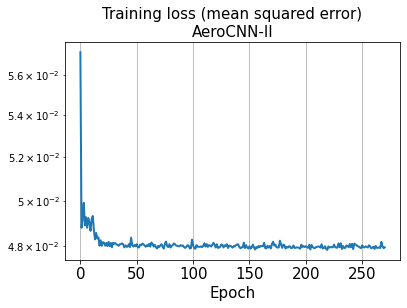

In [35]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

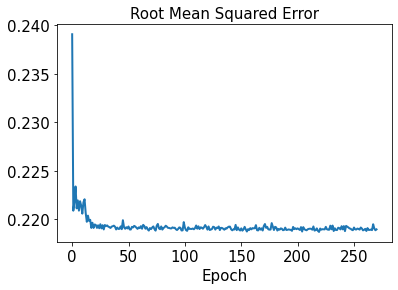

In [36]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

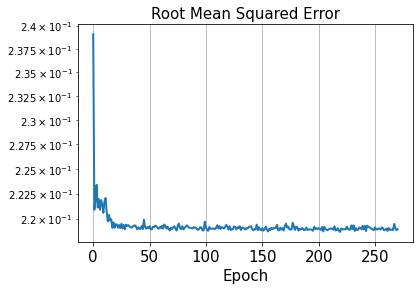

In [37]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [38]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train, y_train)

56/56 [==============================] - 0s 6ms/step - loss: 0.0484 - rmse: 0.2199


In [39]:
test_results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 13ms/step - loss: 0.0473 - rmse: 0.2175


In [40]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

56/56 [==============================] - 0s 4ms/step


In [41]:
decoded_train.shape

(1792, 2, 1)

In [42]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [43]:
decoded_test.shape

(112, 2, 1)

In [44]:
cl_train_refrained = decoded_train[:,0,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cl_test_refrained = decoded_test[:,0,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cd_train_refrained = decoded_train[:,1,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cd_test_refrained = decoded_test[:,1,:]*(np.max(cl)+np.min(cl)) + np.min(cl)

In [45]:
cl_train_refrained.shape

(1792, 1)

In [46]:
cd_train_refrained.shape

(1792, 1)

In [47]:
cd_test_refrained.shape

(112, 1)

In [48]:
x_train.shape[0]

1792

In [49]:
decoded_train = np.concatenate((cl_train_refrained.reshape((int(x_train.shape[0]/2),2,1)),
                                cd_train_refrained.reshape((int(x_train.shape[0]/2),2,1))), axis=0)
decoded_test = np.concatenate((cl_test_refrained.reshape((int(x_test.shape[0]/2),2,1)),
                               cd_test_refrained.reshape((int(x_test.shape[0]/2),2,1))), axis=0)

In [50]:
error_train_abs = np.abs(decoded_train - y_train)

In [51]:
error_test_abs = np.abs(decoded_test - y_test)

In [52]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [53]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [54]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [55]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [56]:
os.chdir("D:\\TrainedModels\\20221024")
model.save('AeroCNN-II_ClCd_nGrid128_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05(normalized)(1x1convAdded).h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [57]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

2.6767311906314504


In [58]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

2.683355133954651


In [59]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

2.366029156069151


In [60]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

4.003846766747908


In [61]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

2.3748948087621025


In [62]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

3.996187404142617


In [63]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[4.582213232857642, 4.951591873113191, 5.187654258938324, 4.335805284857192, 3.5861642304452674, 3.0836841853549486, 2.751128115226296, 2.5261700475988267, 2.4051128183958195, 2.3473669392885954, 2.4067311742361506, 2.3846227022334587, 2.1396737913511443, 2.296812868573686, 1.9813827599753642, 1.7687976045573568, 4.71745912127884, 5.399048067396134, 5.322497920736033, 4.597237105794839, 3.929134133788553, 3.394705747247164, 3.0087147045482743, 2.747920969620805, 2.6147587819058957, 2.5692574566488777, 2.6544022224641353, 2.625011454830873, 2.57212275182706, 2.494569163552598, 2.144859936990824, 1.9742725895870188, 4.2625547089653955, 6.770558315954806, 5.066168393941646, 4.020082994998315, 3.3666058353864887, 2.934963492620374, 2.6355182813151736, 2.4238834932442543, 2.2773691381730745, 2.185435954239016, 2.1434321863929355, 2.111828435910785, 2.102043801359373, 2.1310636452865723, 2.0532192561456655, 1.8722646439036226, 4.867655713150543, 6.26466875324437, 5.705012161442558, 4.3963346

In [64]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[4.683246489880672, 5.176810007688704, 5.657341036905284, 4.620590105143119, 3.770671187638458, 3.2173040986914265, 2.845834380815167, 2.602741653303492, 2.45497323463113, 2.4055768563361197, 2.565163461072508, 2.4840640551762094, 2.3964094098000728, 2.3482675690414365, 2.0486786068058676, 2.0642027588365117, 10.584357391491695, 6.876525944977861, 5.08228612515735, 4.057069269509539, 3.4100467413290874, 2.9807542551557877, 2.6746394841978227, 2.449973710804604, 2.2829221077219155, 2.164130974615269, 2.085392080566684, 2.048672870473603, 2.052748362648605, 2.1502128832202154, 2.2533808213245416, 2.0010948747745347, 4.633191211425056, 5.453011950402502, 5.677475521005953, 4.64489208006545, 3.780055887201363, 3.222203936900967, 2.8516475715811795, 2.5995861506159628, 2.423491907963141, 2.352759547137541, 2.594535989699366, 2.5010296399844276, 2.3370876376478695, 2.03382493605428, 2.010350999880099, 1.8279279680372893, 5.048814518940807, 6.637925129539911, 6.186370174530456, 4.979917086530

In [65]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[4.559357932679978, 4.450383704405405, 4.268356667069649, 3.4963195569465757, 2.977733147191026, 2.62201598698332, 2.377242458786504, 2.2069523710888737, 2.103459551716609, 2.04485988265809, 2.091968664299693, 2.089265915888872, 1.9421327378607178, 2.0704771488168827, 1.894727594109546, 1.7644879878363835, 4.332939389061959, 4.472347372155399, 4.215008084419419, 3.692220319125861, 3.2267837752888333, 2.845081664159005, 2.56430737850752, 2.3717964297246326, 2.264159701115106, 2.2146574233596317, 2.272899043842429, 2.269217584444114, 2.256192560847083, 2.2302453115819536, 2.0456647567197135, 1.9348132936429636, 3.7188720491194704, 5.2412370415098275, 4.030982989897054, 3.2896944513685065, 2.8223599736620217, 2.5102421208138903, 2.2910660996057666, 2.134206915071759, 2.023549914973125, 1.9515365876880615, 1.9138121847077503, 1.8802777750770696, 1.868477708181062, 1.8841165654291105, 1.824625399864416, 1.8312421904574556, 4.818280850619971, 4.995348922460176, 4.482011359563423, 3.559326270

C:\Users\cfdML\AppData\Local\Temp\ipykernel_13540\3393913503.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))


In [66]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[4.605547665485553, 5.799750554878316, 8.590783243276297, 21.671732584168346, 89.75490844873605, 1638.7822227581114, 181.56513616737533, 51.95063049993051, 15.225197341686638, 6.277235326506964, 4.63565114357305, 3.7837051759711784, 2.662534307669955, 2.8918054465907037, 2.107181301586801, 1.7731951121128438, 5.294552328301237, 8.42443698565093, 17.729983779152104, 45.007024064574566, 140.53531026237488, 265.6970691072805, 162.02110114336952, 83.46628874163214, 26.122579746262176, 10.35599814803465, 6.132439211361226, 4.418377867484834, 3.6875097645850343, 3.191562041278899, 2.2869308643629256, 2.02027052651985, 5.46605323881954, 37.76489151950886, 65.50535924468741, 101.71109309692886, 135.9812653710703, 140.2466656709003, 108.61936936763058, 74.2693839668296, 46.424706319840624, 28.077397729499804, 16.25682502818642, 9.173014115470327, 7.378309906082792, 5.549959789580697, 3.7864061937840208, 1.921477839691889, 4.919137349615131, 12.817192123036161, 50.34331222219248, 111.41002881674

C:\Users\cfdML\AppData\Local\Temp\ipykernel_13540\2936306435.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))


In [67]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

135.9812653710703

In [68]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[4.610570441124032, 4.525122014521923, 4.466144602324783, 3.7144396333516836, 3.1141500347687585, 2.71787847673662, 2.447449778752711, 2.266834528148529, 2.1501294514206273, 2.098464593939767, 2.206882649803574, 2.162297086570189, 2.122538565793404, 2.113899186760163, 1.9417201513689724, 1.9835959654458624, 8.061491013760158, 5.315871322492369, 4.044299223431764, 3.3165621262394835, 2.8535313622971143, 2.5433344368190034, 2.3197213230793476, 2.1536871851676374, 2.0285089954984583, 1.937856843087802, 1.8756899409462031, 1.8427269360792264, 1.8354713089821506, 1.8972982681191373, 1.9934799804426078, 1.9684072608300511, 4.459358011008274, 4.969769877615954, 4.467361846686569, 3.7356268376578714, 3.1227423934913303, 2.7213485657377903, 2.451724191696426, 2.2656588356891514, 2.1324810646566483, 2.06836049566383, 2.2317065849702042, 2.171305282904942, 2.078362179311306, 1.8964764739465916, 1.9107992456492606, 1.8161178903610786, 4.640356770597342, 5.413955288218768, 4.827198496272381, 3.9711

In [69]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[4.760843351228336, 6.491979129839662, 16.97994097363648, 68.85509905744505, 171.48938032601518, 447.6598806350963, 304.33863584555, 102.0524421539452, 30.9017785116725, 11.569324116666111, 5.754797171908548, 4.0968046490398935, 3.3232340529078077, 2.9564341335189854, 2.215404830630275, 2.1738554818419304, 31.011963731678946, 49.77323667728783, 76.32432381913462, 107.1270170424524, 132.33998182811231, 135.15973319181793, 110.47218843605783, 79.06138535463288, 52.978141553470124, 35.251416573600615, 23.222307003929796, 14.760681891150265, 8.461201607212137, 5.158195425525908, 3.3715232174139222, 2.0380024601184257, 4.838663069500977, 6.193114754885581, 20.722838588852586, 99.19097633731113, 282.4226740789195, 425.08239437036127, 311.02702845472623, 138.91073660751462, 57.65928218914816, 18.06943149492539, 9.690857632842457, 4.294648585630911, 3.188810341337555, 2.293549925210941, 2.162817428664287, 1.840367527599376, 5.652972546391635, 10.820204041813032, 27.14810804602189, 74.546342338

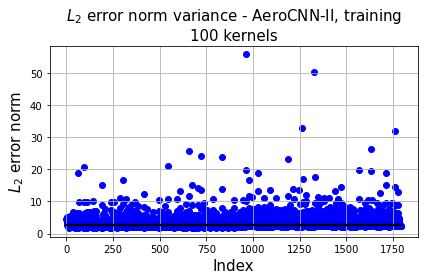

In [70]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

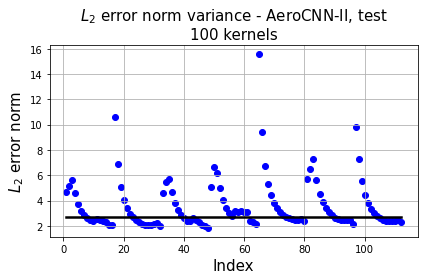

In [71]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

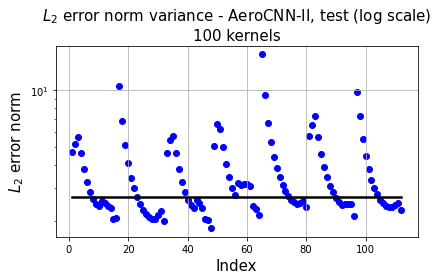

In [72]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

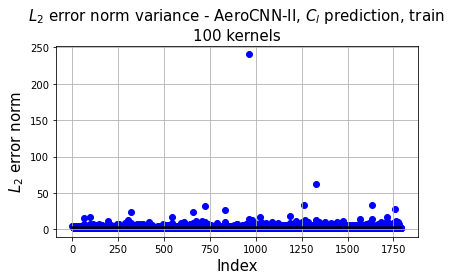

In [73]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

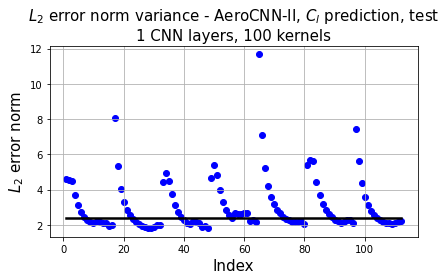

In [74]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

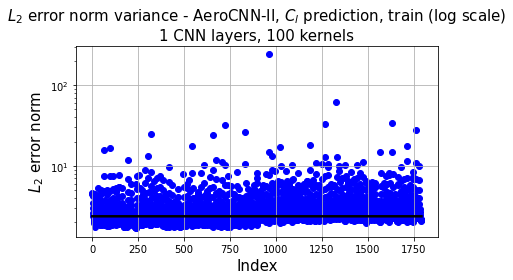

In [75]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

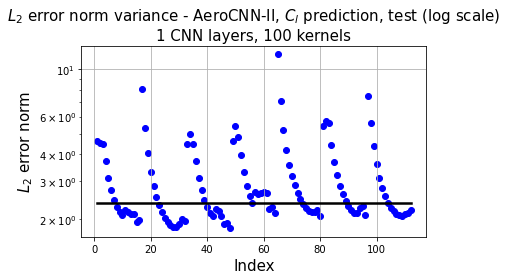

In [76]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

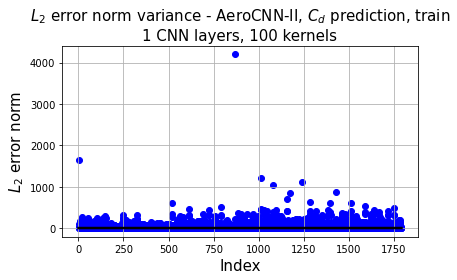

In [77]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

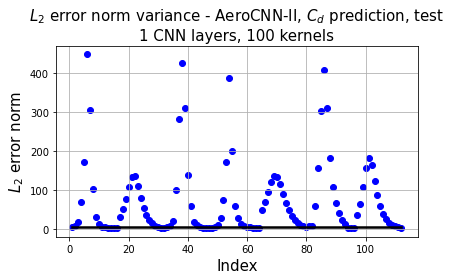

In [78]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

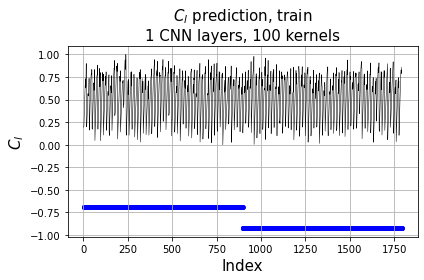

In [79]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

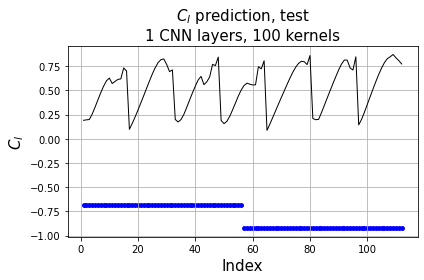

In [80]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

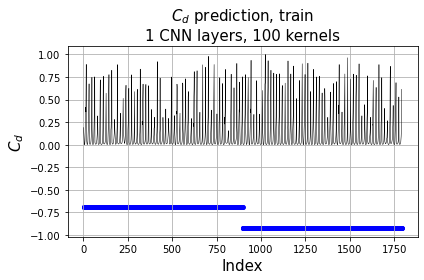

In [81]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

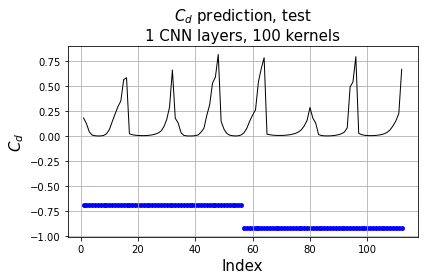

In [82]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

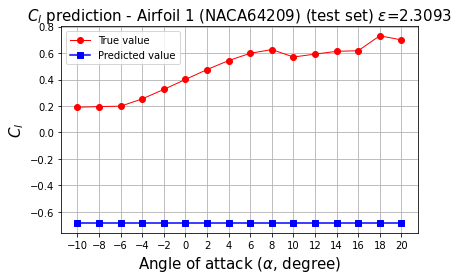

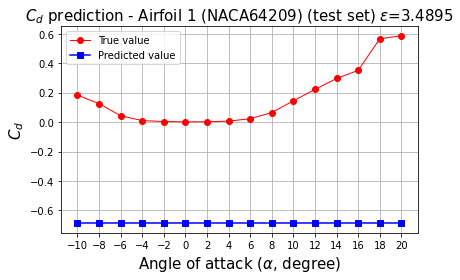

In [83]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

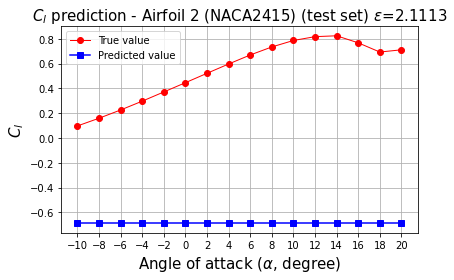

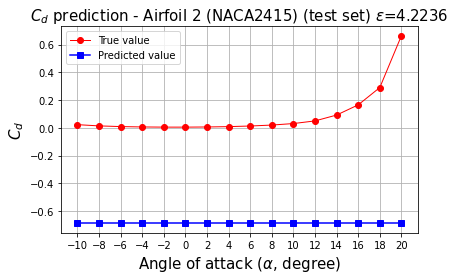

In [84]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

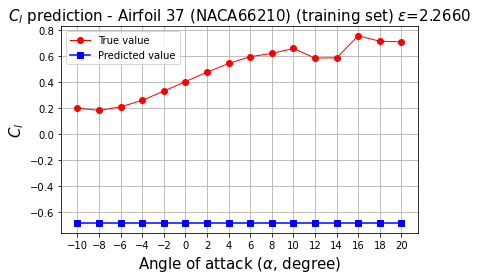

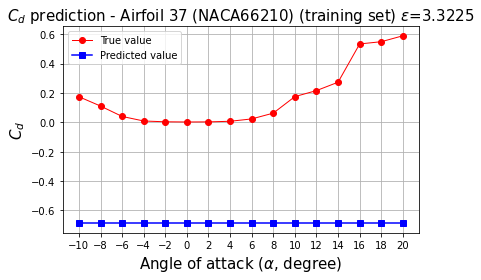

In [85]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

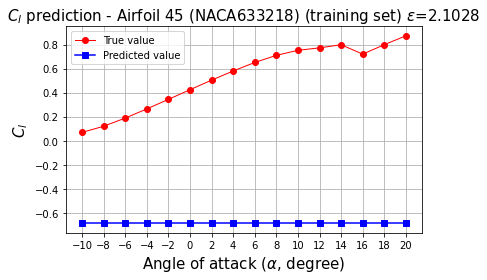

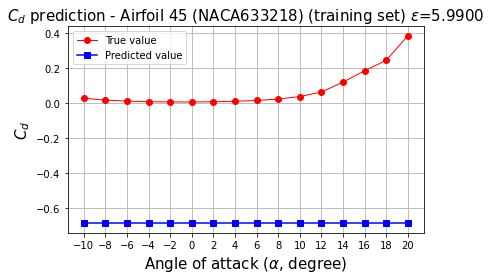

In [86]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

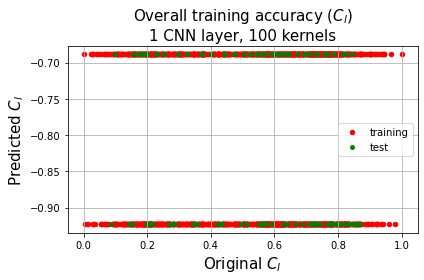

In [87]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

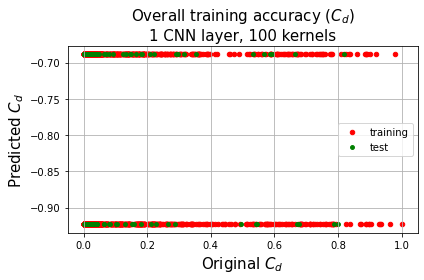

In [88]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

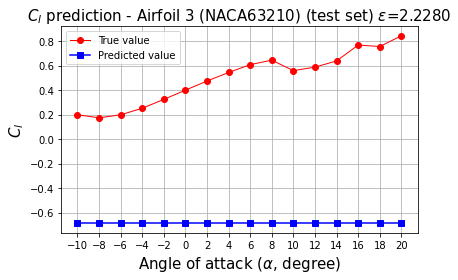

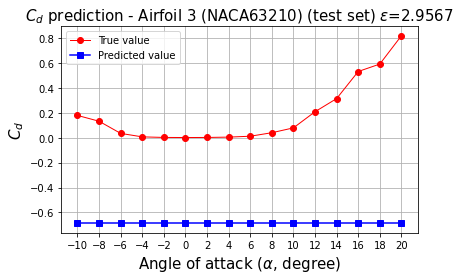

In [89]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

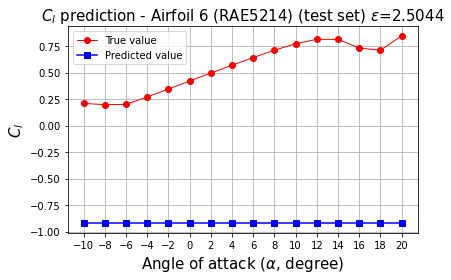

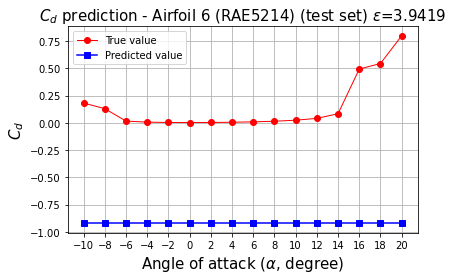

In [90]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()